In [1]:
import numpy as np
import scipy.sparse as sp
import re
import json
import time

from scipy.sparse import linalg as spl
from collections import defaultdict
from IPython.display import Markdown, display

import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
words = np.load('top_25k_words.npy')
bow_subset = sp.load_npz('bow_subset.npz')
N = bow_subset.shape[0]

with open('reviews_subset.json' , 'r') as f:
    reviews = json.load(f)

In [3]:
print(bow_subset.shape)

(100000, 25000)


In [4]:
print(words)

['food' 'good' 'place' ... "burke's" 'electronica' 'peels']


In [5]:
reviews[0]

{'biz': {'categories': ['Restaurants', 'Steakhouses'],
  'city': 'Las Vegas',
  'name': "Gallagher's Steakhouse"},
 'business_id': 'nnDLapJk1z2NJE0-XzwMlQ',
 'review_id': '0Lx-agcwqjNhS4JtCVqkHQ',
 'stars': 5,
 'text': "The surf and turf here was one of the best I've had.\n\nFilet mignon and lobster tail was very good.  i generally dont think the food in Vegas is great, but after being dissappointed on many occasions, I was pleasantly surprised with the quality of our meal.  Thanks to the Taste, i was lured to this restaurant only to find that it is a somehat hidden jewel in New York New York close to the sometimes obnoxious piana bar time square.  \n\nThe side of green beans were delish and the potatos are just meh.\n\nFor desert they  served an extremely delicious lemon pudding which taste more tart than pudding....it was fabulous.\n\nI think Gallaghers is good for couples, groups, and even kids.",
 'user_id': 'M63uPVZtCv7ReY2RgJRmOw'}

In [23]:
def cosine_distance(X, i, j):
    """Compute cosine distance between two rows of a sparse matrix.
    
    Parameters
    ----------
    X : sp.spmatrix, shape [N, D]
        Sparse data matrix.
    i : int
        Index of the first row.
    j : int
        Index of the second row.
        
    Returns
    -------
    d : float
        Cosine distance between the two rows of the sparse matrix.
        
    """
    i_norm = spl.norm(X[i])
    j_norm = spl.norm(X[j])
    ij_dot = X[i].dot(X[j].T)[0, 0]
    
    return 1-ij_dot/(i_norm*j_norm)

In [20]:
def LSH(X, b=8, r=32, d=0.3):
    """Find candidate duplicate pairs using LSH and refine using exact cosine distance.
    
    Parameters
    ----------
    X : sp.spmatrix, shape [N, D]
        Sparse data matrix.
    b : int
        Number of bands.
    r : int
        Number of rows per band.
    d : float
        Distance treshold for reporting duplicates.
    
    Returns
    -------
    duplicates : {(ID1, ID2, d_{12}), ..., (IDX, IDY, d_{xy})}
        A set of tuples indicating the detected duplicates.
        Each tuple should have 3 elements:
            * ID of the first review
            * ID of the second review
            * The cosine distance between them
    
    n_candidates : int
        Number of detected candidate pairs.
        
    """
    np.random.seed(158)
    n_candidates = 0
    duplicates = set()
    
    ### YOUR CODE HERE ###
    
    
    candidates = []
    #create signature matrix size #by all number of documents and wanted number of hash
    random_planes = np.zeros((bow_subset.shape[1], b * r))
    for i in range(b * r):
        random_planes[:, i] = np.random.normal(0, 1, bow_subset.shape[1])
    signature_matrix = bow_subset.dot(random_planes)

    # go over all hashed signature matrix , if matrix index> 0 means we are one side of
    # the random plane(indicated as 1), if index<0 means we are another side of random plane(indicated as 0)
    for k in range(signature_matrix.shape[1]):
        for v in range(signature_matrix.shape[0]):
            if signature_matrix[v, k] >= 0:
                signature_matrix[v, k] = 1
            else:
                signature_matrix[v, k] = 0


    #get signature matrix by dividing it small matrixes as size row size b  
    for s in range(b):
        dictionary = {}
        for review in range(bow_subset.shape[0]):
            b = ''.join(map(str, signature_matrix[review, (s * r):((s + 1) * r)]))
            hash_value = hash(b)
            if hash_value in dictionary.keys():
                dictionary[hash_value].append(review)
            else:
                dictionary[hash_value] = [review]

        #if there is more than one thing inside the dictionary row, that means we found candidate:
        #we need to get all pairs from that row as follow:
        for k, v in dictionary.items():
            if len(dictionary[k]) > 1:
                list_of_pairs = [(v[p1], v[p2]) for p1 in range(len(v)) for p2 in range(p1 + 1, len(v))]
                candidates.append(list((list_of_pairs, 0)))

    n_candidates = len(candidates)

    #calculate all pair wise cosine similairty in candidates
    #candidate list is like this: ((23,455), 0.1) -> document 23 and 455 has 0.1 cosine distance
    for i in range(len(candidates)):
        index1 = candidates[i][0][0][0]
        index2 = candidates[i][0][0][1]
        cos = cosine_distance(bow_subset, index1,  index2)
        candidates[i][1] = cos

    real_result = []
    for i in range(len(candidates)):
        if candidates[i][1] < d:   #get pairs only with cos dis is smaller than d threshold
            real_result.append(candidates[i])

    #only eliminate duplicated results(change duplicated list to set(there is no duplication in sets))
    duplicates = set((real_result[i][0][0][0], real_result[i][0][0][1], real_result[i][1]) for i in range(len(real_result)))

    return duplicates, n_candidates

In [24]:
duplicates, n_candidates = LSH(bow_subset, b=6, r=28, d=0.2)


In [25]:
print('We detected {} candidates.'.format(n_candidates))

We detected 845 candidates.


In [26]:
duplicates

{(1809, 13244, 0.0),
 (6600, 93310, 0.0),
 (17779, 72702, 1.1102230246251565e-16),
 (32066, 71726, 0.0),
 (35163, 82597, 1.1102230246251565e-16),
 (42795, 95179, 0.0),
 (47940, 65607, 0.0),
 (64525, 70002, 0.12712843905603044)}

In [27]:
similar_review_pairs = []
for ix1, ix2, sim in duplicates:
    rev1 = reviews[ix1]
    rev2 = reviews[ix2]
    similar_review_pairs.append((rev1, rev2, sim))
    
pattern = re.compile('(\S+|\n)')
pattern_punctuation = re.compile('^\W+|\W+$')

def highlight_vocabulary(text, vocabulary):
    split = re.findall(r"[\w']+", text)
    in_vocabulary = [pattern.sub(lambda m: pattern_punctuation.sub('', m.group()), str.lower(x)) in words for x in split]
    highlighted_words = ["**{}**".format(x) if in_vocabulary[ix] else x for ix,x in enumerate(split) ]
    highlighted_text = " ".join(highlighted_words)
    return highlighted_text

def printmd(string):
    display(Markdown(string))


for r1, r2, sim in similar_review_pairs:
    if not np.isclose(sim, 0.0):
        printmd(highlight_vocabulary(r1['text'], words))
        print("")
        print("vs.")
        print("")
        printmd(highlight_vocabulary(r2['text'], words))
        print("===")
        print("Same business: {}".format(r1['business_id'] == r2['business_id']))
        print("Same user: {}".format(r1['user_id'] == r2['user_id']))
        print("Cosine distance {:.4f}".format(sim))
        print("")    
        print("#######")
        print("")


**Good** **Service** **Good** **food**


vs.



**Service** is **good** very **friendly** and **good** **food** who **could** **want** more nagar it was very **good**

===
Same business: False
Same user: False
Cosine distance 0.1271

#######



In [28]:
# naively compute the duplicates using a double for loop
def naive_duplicates(X, d = 0.2):
    """
    Parameters
    ----------
    X : sp.spmatrix, shape [N, D]
        Sparse data matrix.
    d : float
        Distance treshold for reporting duplicates.
    
    Returns
    -------
    duplicates : {(ID1, ID2, d_{12}), ..., (IDX, IDY, d_{xy})}
        A set of tuples indicating the detected duplicates.
        Each tuple should have 3 elements:
            * ID of the first review
            * ID of the second review
            * The cosine distance between them
    """
    N = X.shape[0]
    duplicates = set()
    for i in range(N):
        for j in range(N):
            d_ij = cosine_distance(X, i, j)
            if d_ij < d and i != j:
                duplicates.add((i, j, d_ij))
    return duplicates

In [29]:
def runtime_comparison():
    """
    Compare the runtime between LSH and the naive approach.
    
    Returns
    -------
    trace : [(n1, lsh_dur, naive_dur), (n2, lsh_dur, naive_dur), ... ]
            A list of tuples with execution times for different number of reviews.
            Each tuple should have 3 elements:
                * number of reviews considered
                * duration of the LSH approach
                * duration of the naive approach
    """
    trace = []
    for n in np.arange(25, 251, 25):
        print('Running comparison for {} reviews.'.format(n))
        
        ### YOUR CODE HERE ###
        start = time.time()
        LSH(bow_subset[:n], b=6, r=28, d=0.2)
        end = time.time() - start

        start_naive = time.time()
        naive_duplicates(bow_subset[:n], d=0.2)
        end_naive = time.time() - start_naive
        print('Naive time: ', end_naive,' seconds')
        print('LHS time: ', end,' seconds')

        trace.append((n, end, end_naive))
    return trace

In [30]:
trace = runtime_comparison()

Running comparison for 25 reviews.
Naive time:  0.44322705268859863  seconds
LHS time:  16.85658025741577  seconds
Running comparison for 50 reviews.
Naive time:  1.7747151851654053  seconds
LHS time:  16.85270667076111  seconds
Running comparison for 75 reviews.
Naive time:  4.757646322250366  seconds
LHS time:  18.41991901397705  seconds
Running comparison for 100 reviews.
Naive time:  7.636318206787109  seconds
LHS time:  18.200227737426758  seconds
Running comparison for 125 reviews.
Naive time:  12.04703950881958  seconds
LHS time:  16.114455938339233  seconds
Running comparison for 150 reviews.
Naive time:  17.187649250030518  seconds
LHS time:  16.235074758529663  seconds
Running comparison for 175 reviews.
Naive time:  24.51213526725769  seconds
LHS time:  16.895872592926025  seconds
Running comparison for 200 reviews.
Naive time:  29.850348711013794  seconds
LHS time:  16.225059986114502  seconds
Running comparison for 225 reviews.
Naive time:  36.8639440536499  seconds
LHS ti

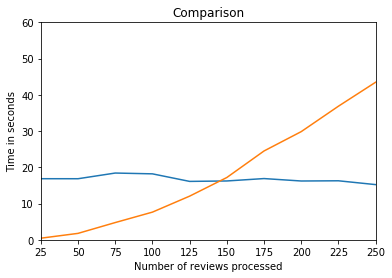

In [31]:
#My LSH implementation takes 15 seconds regardless of input size, it is little longer than example code you provided but still
# O(N) complexity
plt.ylim([0,60])
plt.xlim([25, 250])

plt.plot( [y[0] for y in trace],  [y[1] for y in trace]) 
plt.plot(  [y[0] for y in trace],  [y[2] for y in trace]) 

plt.title('Comparison')
plt.ylabel('Time in seconds')
plt.xlabel('Number of reviews processed')
plt.show()